In [154]:
import torch
import torchvision
from torchvision.transforms import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import os
import glob

In [155]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)
print(device)

cuda


In [156]:
image_dir = './'
train_path = './train'
test_path = './test'
print(os.getcwd())
print(os.listdir(image_dir))

/mnt/c/code/ResNet
['.git', 'ResNet50.ipynb', 'ResNet50_2.ipynb', 'test', 'train']


In [157]:
resize_trans = transforms.Compose([
                                   transforms.Resize((224,224)),
                                   transforms.ToTensor()
])
resize_train = torchvision.datasets.ImageFolder(root = train_path, transform=resize_trans)
resize_test = torchvision.datasets.ImageFolder(root = test_path, transform=resize_trans)

In [158]:
resize_train[0][0].shape

torch.Size([3, 224, 224])

In [159]:
resize_train[0][0]

tensor([[[0.8157, 0.8157, 0.8157,  ..., 0.7922, 0.7961, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8000, 0.8039, 0.7961],
         [0.8196, 0.8196, 0.8235,  ..., 0.7961, 0.8000, 0.8039],
         ...,
         [0.3294, 0.3294, 0.3294,  ..., 0.3216, 0.3216, 0.3216],
         [0.2471, 0.2471, 0.2471,  ..., 0.2392, 0.2392, 0.2392],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.8314, 0.8314, 0.8314,  ..., 0.9216, 0.9137, 0.9098],
         [0.8314, 0.8314, 0.8314,  ..., 0.9333, 0.9294, 0.9216],
         [0.8353, 0.8353, 0.8353,  ..., 0.9412, 0.9373, 0.9294],
         ...,
         [0.2941, 0.2941, 0.2941,  ..., 0.2863, 0.2863, 0.2863],
         [0.2196, 0.2196, 0.2196,  ..., 0.2157, 0.2157, 0.2157],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.5333, 0.5333, 0.5333,  ..., 0.6314, 0.6314, 0.6314],
         [0.5333, 0.5333, 0.5333,  ..., 0.6510, 0.6471, 0.6392],
         [0.5373, 0.5373, 0.5373,  ..., 0.6549, 0.6471, 0.

In [160]:
import numpy as np
np.mean(resize_train[0][0].numpy(),axis=(1,2)) # numpy로 바꾸고, axis = 1,2 mean으로 RGB mean/std 뽑기

array([0.41069302, 0.39221713, 0.41666004], dtype=float32)

In [161]:
def get_mean_std(dataset):
  meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
  stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

  meanR = np.mean([m[0] for m in meanRGB])
  meanG = np.mean([m[1] for m in meanRGB])
  meanB = np.mean([m[2] for m in meanRGB])

  stdR = np.mean([s[0] for s in stdRGB])
  stdG = np.mean([s[1] for s in stdRGB])
  stdB = np.mean([s[2] for s in stdRGB])

  return [meanR, meanG, meanB], [stdR, stdG, stdB]

In [162]:
resize_train_mean, resize_train_std = get_mean_std(resize_train)
resize_test_mean, resize_test_std = get_mean_std(resize_test)
print(resize_train_mean, resize_train_std)
print(resize_test_mean, resize_test_std)

[0.32228306, 0.3132489, 0.23934957] [0.2373611, 0.23408231, 0.16941062]
[0.41139412, 0.4154398, 0.41603127] [0.18583775, 0.20790222, 0.18237266]


In [163]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)), # 이미지 resize
    transforms.RandomCrop(210), # 이미지를 랜덤으로 크롭
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 지터링(밝기, 대조, 채비, 색조)
    transforms.RandomHorizontalFlip(p = 0.5), # p확률로 이미지 좌우반전
    transforms.RandomVerticalFlip(p = 0.5), # p확률로 상하반전
    transforms.ToTensor(),
    transforms.Normalize(resize_train_mean, resize_train_std)
])
"""
transform_train = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomCrop(210), # 이미지를 랜덤으로 크롭
    transforms.ToTensor(),
    transforms.Normalize(resize_train_mean, resize_train_std)
])
"""
transform_test = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomCrop(210), # 이미지를 랜덤으로 크롭
    transforms.ToTensor(),
    transforms.Normalize(resize_test_mean, resize_test_std)
])
"""
transform_test = transforms.Compose([
    transforms.Resize((224, 224)), # 이미지 resize
    transforms.RandomCrop(210), # 이미지를 랜덤으로 크롭
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 지터링(밝기, 대조, 채비, 색조)
    transforms.RandomHorizontalFlip(p = 0.5), # p확률로 이미지 좌우반전
    transforms.RandomVerticalFlip(p = 0.5), # p확률로 상하반전
    transforms.ToTensor(),
    transforms.Normalize(resize_test_mean, resize_test_std)
])
"""
trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)


In [164]:
trainloader = DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=0)

testloader = DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=0)

In [165]:
# import resnet
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

# 미리 정의
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [166]:
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.dilation = 1

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0]) # 3 반복
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) # 4 반복
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2) # 6 반복
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2) # 3 반복
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [167]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 3, True).to(device) 
# resnet50
# 1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) +1(fc)= ResNet50

In [168]:
from torchsummary import summary
summary(resnet50, input_size=(3, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 7, 7])


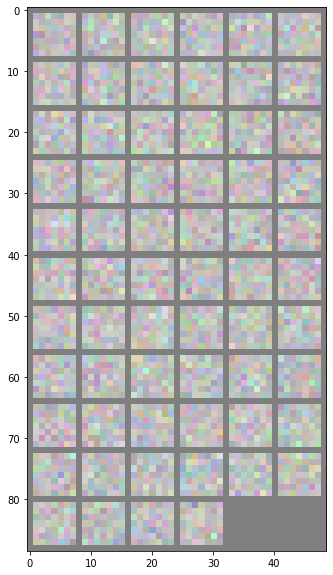

In [169]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
for w in resnet50.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# 가중치 renormalization
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=6, padding=1)

plt.figure(figsize=(10, 10))
imshow(x_grid)

In [170]:
class Config:
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

In [171]:
lr = 0.0004
epochs = 50
optimizer = 'Adam'

In [172]:
config = Config(
    trainloader = trainloader,
    testloader = testloader,
    model = resnet50,
    device = device,
    optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr),
    criterion= nn.CrossEntropyLoss().to(device),
    globaliter = 0
)

In [173]:
class train_test():
      def __init__(self, config):
        # 파라미터 인자
        self.trainloader = config.trainloader
        self.testloader = config.testloader
        self.model = config.model
        self.device = config.device
        self.optimizer = config.optimizer
        self.criterion = config.criterion
        self.globaliter = config.globaliter
        print(len(trainloader))
      def train(self, epochs, log_interval):
          self.model.train()
          trained_outputs = []
          tested_outputs = []
          for epoch in range(1, epochs + 1 ):  # epochs 루프
              running_loss = 0.0
              lr_sche.step()
              for i, data in enumerate(self.trainloader, 0): # batch 루프
                  # get the inputs
                  self.globaliter += 1
                  inputs, labels = data # input data, label 분리
                  inputs = inputs.to(self.device)
                  labels = labels.to(self.device)

                  # 가중치 초기화 -> 이전 batch에서 계산되었던 가중치를 0으로 만들고 최적화 진행
                  self.optimizer.zero_grad() 

                  # forward + backward + optimize
                  outputs = self.model(inputs)
                  trained_outputs.append(outputs.detach().cpu().numpy())
                  loss = self.criterion(outputs, labels)
                  loss.backward()
                  self.optimizer.step()
                  running_loss += loss.item()

                  # 30 iteration마다 acc & loss 출력
                  if i % log_interval == log_interval -1 : # i는 1에포크의 iteration
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlearningLoss: {:.6f}\twhole_loss: {:.6f} '.format(
                        epoch, i*len(inputs), len(self.trainloader.dataset),
                        100. * i*len(inputs) / len(self.trainloader.dataset), 
                        running_loss / log_interval,
                        loss.item()))
                    running_loss = 0.0

                    #with train_summary_writer.as_default():
                    #    summary.scalar('loss', loss.item() , step = self.globaliter)
              
              with torch.no_grad():
                  self.model.eval()
                  correct = 0
                  total = 0
                  test_loss = 0
                  acc = []
                  for k, data in enumerate(self.testloader, 0):
                    images, labels = data
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(images)
                    tested_outputs.append(outputs.detach().cpu().numpy())
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    test_loss += self.criterion(outputs, labels).item()
                    acc.append(100 * correct/total)
                  
                  print('\nTest set : Average loss:{:.4f}, Accuracy: {}/{}({:.0f}%)\n'.format(
                      test_loss, correct, total, 100 * correct/total
                  ))
                  
                  """
                  with test_summary_writer.as_default():
                      summary.scalar('loss', test_loss , step = self.globaliter)
                      summary.scalar('accuracy', 100 * correct/total , step = self.globaliter)  
                      if acc [k] > 60 and acc[k] > acc[k-1]:
                         torch.save({
                                     'epoch': epoch,
                                     'model_state_dict': self.model.state_dict(),
                                     'optimizer_state_dict': self.optimizer.state_dict(),
                                     'loss': test_loss
                                     }, PATH)
                  """
          return trained_outputs, tested_outputs
      
      print('Finished Training')

Finished Training


In [174]:
ready_to_train=train_test(config)

5


In [175]:
lr_sche = optim.lr_scheduler.StepLR(config.optimizer, step_size=20, gamma=0.5) # 20 step마다 lr조정
epochs = 50
log_interval = 1

trainoutputs, testoutputs = ready_to_train.train(epochs, log_interval)

Train Epoch: 1 [0/50 (0%)]	learningLoss: 1.299404	whole_loss: 1.299404 
Train Epoch: 1 [10/50 (20%)]	learningLoss: 0.769057	whole_loss: 0.769057 
Train Epoch: 1 [20/50 (40%)]	learningLoss: 0.410429	whole_loss: 0.410429 
Train Epoch: 1 [30/50 (60%)]	learningLoss: 0.215185	whole_loss: 0.215185 
Train Epoch: 1 [40/50 (80%)]	learningLoss: 0.123811	whole_loss: 0.123811 

Test set : Average loss:7.1602, Accuracy: 20/60(33%)

Train Epoch: 2 [0/50 (0%)]	learningLoss: 0.620450	whole_loss: 0.620450 


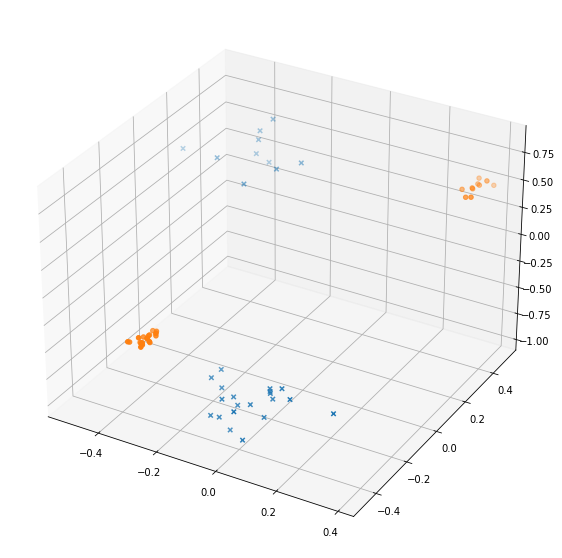

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
tmp = trainoutputs
ax.scatter(tmp[0].T, tmp[1].T, tmp[2].T, marker='x')

tmp = testoutputs
ax.scatter(tmp[0].T, tmp[1].T, tmp[2].T, marker = 'o')
#ax.view_init(0,90)
#ax.view_init(90,0)
#ax.view_init(0,0)
#ax.view_init(45,45)
plt.show()